# **Table of Contents**

1. Importing
* 1a. The Movie Database (tmdb)
* 1b. The Numbers Movie Budgets (movie_budgets)
* 1c. IMDB (alive_directors)
* 1d. Movie Gross (movie_gross)

2. Cleaning Data

3. Merging Data

4. Linear Regression Modelling
* 4a. Vote Average vs. Budget
* 4b. Revenue vs. Budget

5. Visual Data Analysis
* 5a. Studio Analysis
* 5b. Genre Analysis
* 5c. Director Analysis

##
##

# **1. Importing Data**

In [2]:
# Importing packages, setting style for charts

import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd as pt
import warnings

warnings.filterwarnings('ignore')
sns.set_style('darkgrid')

In [3]:
# Reading in the dataframes

movie_info    = pd.read_csv('zippedData/rt.movie_info.tsv.gz', sep='\t')
tmdb          = pd.read_csv('zippedData/tmdb.movies.csv.gz') #tmdb
movie_budgets = pd.read_csv('zippedData/tn.movie_budgets.csv.gz') 
movie_gross   = pd.read_csv("zippedData/bom.movie_gross.csv.gz") 
reviews       = pd.read_csv("zippedData/rt.reviews.tsv.gz", error_bad_lines=False, sep='\t', encoding= 'unicode_escape')

In [4]:
# Reading in the im.db database

# Filtering the database based directors who are still alive
conn = sqlite3.connect('zippedData/im.db/im.db')

q = """

WITH living_directors AS(
SELECT primary_title, start_year, genres, primary_name, death_year, primary_profession 
FROM movie_basics mb
INNER JOIN directors d
    ON mb.movie_id = d.movie_id
INNER JOIN persons p
    ON d.person_id = p.person_id
WHERE primary_profession LIKE '%director%'
GROUP BY mb.movie_id
HAVING p.death_year is NULL
)

SELECT * FROM living_directors

"""

alive_directors = pd.read_sql(q, conn)

##
##

# **2. Cleaning Data**

### 2a. The Movie Database (tmdb)

In [5]:
# Adding a column that concantenates the title and release date of the movie for dataframe merging
tmdb_title = tmdb['original_title']
tmdb_date = tmdb['release_date']
tmdb['title_and_year'] = tmdb_title + ' ' + tmdb_date.apply(lambda x: x[:4])

# Removing duplicates from tmdb
tmdb = tmdb.drop_duplicates(subset='id', keep='first')
tmdb = tmdb.drop_duplicates(subset='title_and_year', keep='first')

### 2b. The Numbers Movie Budgets (movie_budgets)

In [6]:
# Adding a column that concantenates the title and release date of the movie for dataframe merging
movie_budgets_title = movie_budgets['movie']
movie_budgets_date = movie_budgets['release_date']
movie_budgets['title_and_year'] = movie_budgets_title + ' ' + movie_budgets_date.apply(lambda x: x[-4:])

# Creating numeric columns to represent revenue and budget
movie_budgets['revenue'] = movie_budgets['worldwide_gross'].replace('[\$,]','', regex=True).astype(float)
movie_budgets['budget'] = movie_budgets['production_budget'].replace('[\$,]','', regex=True).astype(float)

# Removing duplicates
movie_budgets = movie_budgets.drop_duplicates(subset='title_and_year', keep='first')

### 2c. IMDB (alive_directors)

In [7]:
# Converting the sql database into a dataframe
alive_directors = pd.DataFrame(alive_directors)

# Adding a column that concantenates the title and release date of the movie for dataframe merging
alive_directors_title = alive_directors['primary_title']
alive_directors_year = alive_directors['start_year']
alive_directors['title_and_year'] = alive_directors_title + ' ' + alive_directors_year.apply(lambda x: str(x))

### 2d. Movie Gross (movie_gross)

In [8]:
# Adding a column that concantenates the title and release date of the movie for dataframe merging
movie_gross_title = movie_gross['title']
movie_gross_year = movie_gross['year']
movie_gross['title_and_year'] = movie_gross_title + ' ' + movie_gross_year.astype(str)

#
#

# **3. Merging Data**

In [9]:
# Merging the tmdb, movie_budgets, and alive_directors dataframes
movies = pd.merge(movie_budgets, tmdb, how='inner', on='title_and_year')
movies = pd.merge(movies, alive_directors, how='inner', on='title_and_year')
movies = pd.merge(movies, movie_gross, on='title_and_year')

"""
Filtering to rows that have greater than $0 in revenue. 
Research showed that many of these movies were released directly to streaming services, not theatres
"""
movies = movies.loc[movies['revenue'] != 0]

# Reset index due to dropping rows
movies.reset_index(inplace=True)

# Remove unnecessary columns
columns_to_drop = ['index',
                    'id_x',
                    'id_y',
                    'Unnamed: 0',
                    'primary_title',
                    'title_y', 
                    'original_title',
                    'year', 
                    'title_x', 
                    'domestic_gross_x',
                    'domestic_gross_y',
                    'start_year',
                    'release_date_x',
                    'movie',
                    'production_budget',
                    'foreign_gross',
                    'death_year',
                    'original_language']
movies.drop(columns_to_drop, axis=1, inplace=True)

# Remove rows that have missing values
movies.dropna(inplace=True)
movies.head()

,worldwide_gross,title_and_year,revenue,budget,genre_ids,popularity,release_date_y,vote_average,vote_count,genres,primary_name,primary_profession,studio
0,"$1,045,663,875",Pirates of the Caribbean: On Stranger Tides 2011,1.045664e+09,410600000.0,"[12, 28, 14]",30.579,2011-05-20,6.4,8571,"Action,Adventure,Fantasy",Rob Marshall,"director,miscellaneous,producer",BV
1,"$1,403,013,963",Avengers: Age of Ultron 2015,1.403014e+09,330600000.0,"[28, 12, 878]",44.383,2015-05-01,7.3,13457,"Action,Adventure,Sci-Fi",Joss Whedon,"writer,producer,director",BV
2,"$2,048,134,200",Avengers: Infinity War 2018,2.048134e+09,300000000.0,"[12, 28, 14]",80.773,2018-04-27,8.3,13948,"Action,Adventure,Sci-Fi",Joe Russo,"producer,director,writer",BV
3,"$655,945,209",Justice League 2017,6.559452e+08,300000000.0,"[28, 12, 14, 878]",34.953,2017-11-17,6.2,7510,"Action,Adventure,Fantasy",Zack Snyder,"producer,director,writer",WB
4,"$879,620,923",Spectre 2015,8.796209e+08,300000000.0,"[28, 12, 80]",30.318,2015-11-06,6.4,6719,"Action,Adventure,Thriller",Sam Mendes,"producer,director,miscellaneous",Sony


#
#





# **4. Linear Regression**
> In this section we conducted linear regression tests on the movie's budget, vote average, and revenue to see how they are related

In [10]:
# x, y, and title size for plotting
title_size = 20
label_size = 16

##

### 4a. Vote Average vs. Budget

In [11]:
budget = movies['budget']
vote_average = movies['vote_average']

model = sm.OLS(vote_average, sm.add_constant(budget))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           vote_average   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     12.95
Date:                Fri, 23 Jun 2023   Prob (F-statistic):           0.000337
Time:                        00:50:59   Log-Likelihood:                -1088.4
No. Observations:                 935   AIC:                             2181.
Df Residuals:                     933   BIC:                             2190.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.3166      0.034    185.295      0.000       6.250       6.383
budget      1.549e-09    4.3e-10      3.598      0.000    7.04e-10    2.39e-09
==============================================================================
Omnibus:                        1.610   Durbin-Watson:                   1.807
Prob(Omnibus):                  0.447   Jarque-Bera (JB):                1.681
Skew:                          -0.095   Prob(JB):                        0.432
Kurtosis:                       2.914   Cond. No.                     1.06e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.06e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

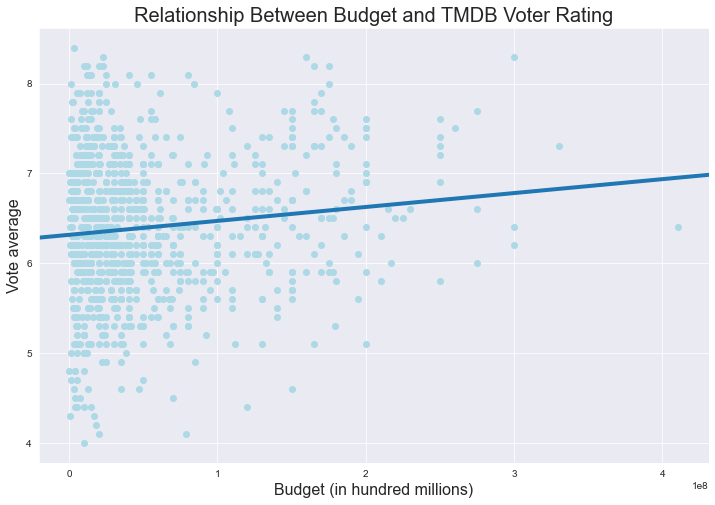

In [12]:
# Plotting the vote_average vs. budget
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(budget, vote_average, color='lightblue')
ax.set_xlabel('Budget (in hundred millions)', fontsize=label_size)
ax.set_ylabel('Vote average', fontsize=label_size)
ax.set_title('Relationship Between Budget and TMDB Voter Rating', fontsize=title_size)
sm.graphics.abline_plot(model_results=results, ax=ax, linewidth=4);

> Our p-values demonstrate the model is statistically significant, but the R-squared value of 0.014 indicate that only 1.4% of the variability in vote average can be explained by budget. Therefore we conclude that a higher budget is not a very strong predictor for better voter ratings.

##

### 4b. Revenue vs. Budget

In [13]:
budget = movies['budget']
revenue = movies['revenue']
model=sm.OLS(revenue, sm.add_constant(budget))
results=model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.610
Model:                            OLS   Adj. R-squared:                  0.609
Method:                 Least Squares   F-statistic:                     1459.
Date:                Fri, 23 Jun 2023   Prob (F-statistic):          6.60e-193
Time:                        00:50:59   Log-Likelihood:                -18986.
No. Observations:                 935   AIC:                         3.798e+04
Df Residuals:                     933   BIC:                         3.799e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.529e+06   7.01e+06     -0.218      0.827   -1.53e+07    1.22e+07
budget         3.3816      0.089     38.191      0.000       3.208       3.555
==============================================================================
Omnibus:                      424.024   Durbin-Watson:                   1.451
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3941.154
Skew:                           1.834   Prob(JB):                         0.00
Kurtosis:                      12.366   Cond. No.                     1.06e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.06e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

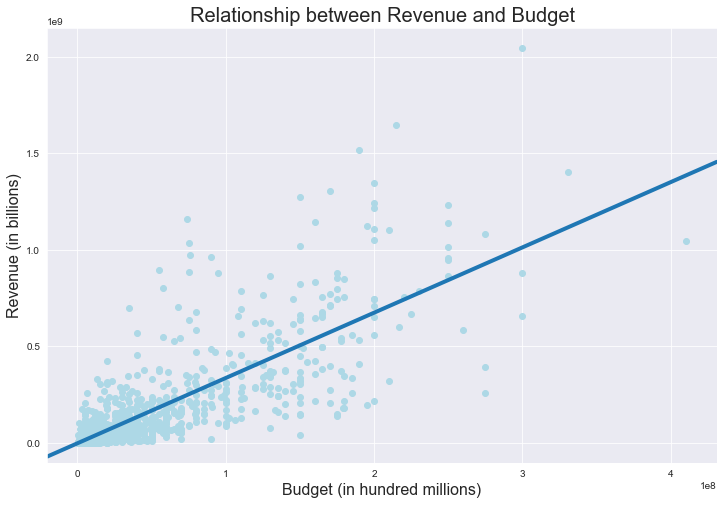

In [14]:
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(budget, revenue, color='lightblue')
ax.set_xlabel('Budget (in hundred millions)', fontsize=label_size)
ax.set_ylabel('Revenue (in billions)', fontsize=label_size)
ax.set_title('Relationship between Revenue and Budget', fontsize=title_size)
sm.graphics.abline_plot(model_results=results, ax=ax, linewidth=4);

In [15]:
# Examining the model metrics:
y_hat = results.params[1] * budget + results.params[0]
MAE = np.mean(abs(revenue-y_hat))
MSE = np.mean((revenue-y_hat)**2)
RMSE = np.sqrt(MSE)

#Compare to baseline model:
MAE_baseline = np.mean(abs(revenue-revenue.mean()))
MSE_baseline = np.mean((revenue-revenue.mean())**2)
RMSE_baseline = np.sqrt(MSE_baseline)

#Confirm the model is better than the baseline model:
assert(MAE < MAE_baseline)
assert(MSE < MSE_baseline)
assert(RMSE < RMSE_baseline)

For every extra \$1 spent in budget, the movie brings in on average \$3.30 dollars extra in revenue

##
##


# **5. Visual Data Analysis**

> In this section we will explore the most common studios and determine which genres, studios, and directors are the most profitable. We define profitability as the ratio of revenue to budget.

##

### 5a. Studio Analysis

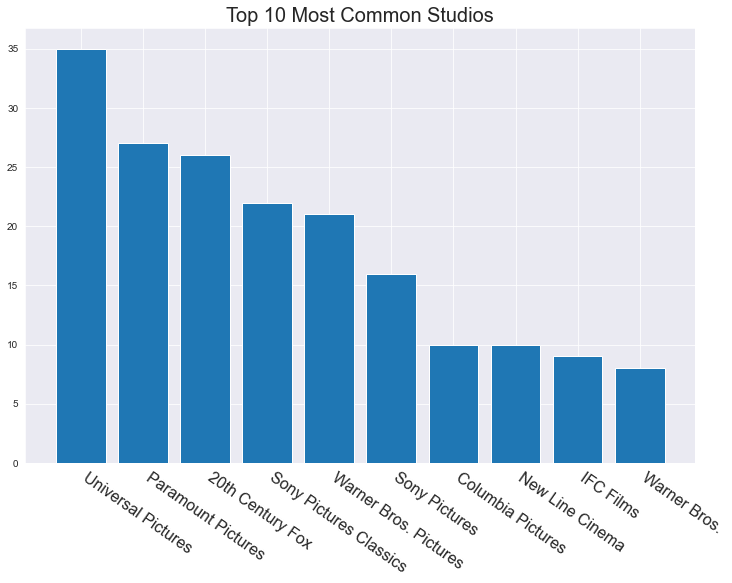

In [16]:
top_10_studio = movie_info['studio'].value_counts()[:10].index
top_10_studio_counts = movie_info['studio'].value_counts()[:10].values

fig, ax = plt.subplots(figsize=(12,8))
ax.bar(top_10_studio, top_10_studio_counts)
ax.set_xticklabels(top_10_studio, rotation=-35, ha='left', fontsize=label_size)
ax.set_title('Top 10 Most Common Studios', fontsize=title_size);

In [17]:
movies['year'] = movies['release_date_y'].apply(lambda x: x[:4]).astype(int)
revenue_by_year = movies.groupby('year')['revenue'].mean()

In [18]:
X = revenue_by_year.index
y = revenue_by_year.values
model = sm.OLS(y, sm.add_constant(X))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.779
Method:                 Least Squares   F-statistic:                     29.17
Date:                Fri, 23 Jun 2023   Prob (F-statistic):            0.00101
Time:                        00:50:59   Log-Likelihood:                -161.96
No. Observations:                   9   AIC:                             327.9
Df Residuals:                       7   BIC:                             328.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.502e+10   4.67e+09     -5.362      0.001   -3.61e+10    -1.4e+10
x1          1.251e+07   2.32e+06      5.401      0.001    7.03e+06     1.8e+07
==============================================================================
Omnibus:                        1.372   Durbin-Watson:                   1.292
Prob(Omnibus):                  0.504   Jarque-Bera (JB):                0.928
Skew:                          -0.553   Prob(JB):                        0.629
Kurtosis:                       1.882   Cond. No.                     1.57e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.57e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [19]:
tmdb_genres={
'Action':          28,
'Adventure':       12,
'Animation':       16,
'Comedy':          35,
'Crime':           80,
'Documentary':     99,
'Drama':           18,
'Family':          10751,
'Fantasy':         14,
'History':         36,
'Horror':          27,
'Music':           10402,
'Mystery':        9648,
'Romance':         10749,
'Science Fiction': 878,
'TV Movie':        10770,
'Thriller':        53,
'War':             10752,
'Western':         37}

# Reverses the key and values of the tmdb_genres dictionary
tmdb_genres_swap = {y:x for x,y in tmdb_genres.items()}

# Converts the ids in genre_ids to a list from a string and replaces the id with its corresponding genre
movies['genre_ids'] = movies['genre_ids'].apply(lambda x: [tmdb_genres_swap.get(int(id), 'X') for id in x.strip('[]').split(',') if len(id) != 0])

# Resetting index and dropping duplicate columns again after removing rows
movies.reset_index(inplace=True)
movies.drop(['index'], axis=1, inplace=True)

In [20]:
movies['revenue_to_budget'] = movies['revenue'] / movies['budget']
genre_rois = {}

for row in movies.index:
    g_ids = movies.iloc[row]['genre_ids']
    rtb = movies.iloc[row]['revenue_to_budget']
    for g in g_ids:
        if g in genre_rois.keys():
            genre_rois[g] = np.append(genre_rois[g], rtb)
        else:
            genre_rois[g] = np.array([rtb])

genre_rois_average = {}
for g in genre_rois.keys():
    genre_rois_average[g] = genre_rois[g].mean()

genre_rois_average

{'Adventure': 3.468424752629892,
 'Action': 3.085738220732371,
 'Fantasy': 3.35252526343265,
 'Science Fiction': 3.8479960979184864,
 'Crime': 2.622949932820052,
 'Drama': 3.642133173239011,
 'Thriller': 6.67669342407395,
 'Western': 1.7272107179948408,
 'Animation': 4.1870257160591775,
 'Family': 3.62842342028393,
 'Comedy': 3.6631098698176787,
 'Horror': 14.756335071943699,
 'Romance': 4.10012005138923,
 'Mystery': 5.4081185248673265,
 'War': 2.9368510723476002,
 'Music': 4.314112050109162,
 'History': 3.048343073997596,
 'Documentary': 5.089371101510462}

#### Does genre have a statistically significant impact on return on investment?
> Before we make recommendations on which genres to invest in, we must first determine whether genre is statistically significant in our data when it comes to predicting return on investment.

In [21]:
stats.f_oneway(*genre_rois.values())

F_onewayResult(statistic=4.788027670798174, pvalue=3.3813161628992655e-10)

> Since our p-value is less than 0.05, we conclude that there is a statistically significant difference in return on investment by genre. Therefore we will conduct further analysis to see which genres are the best investments.

 ##

### 5b. Genre Analysis

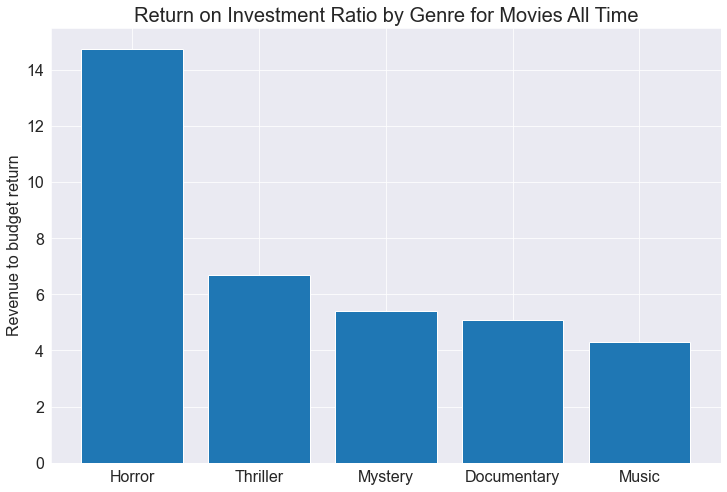

In [22]:
genre_ids = list(genre_rois_average.keys())
rois = list(genre_rois_average.values())
genres_and_rois = pd.DataFrame(data=rois, index=genre_ids, columns={'Return on Investment'})
genres_and_rois.sort_values(by='Return on Investment', ascending=False, inplace=True)

fig, ax = plt.subplots(figsize=(12,8))
ax.bar(genres_and_rois.index[0:5], genres_and_rois['Return on Investment'][0:5])
ax.set_title('Return on Investment Ratio by Genre for Movies All Time', fontsize=title_size)
ax.set_xticklabels(genres_and_rois.index, fontsize=label_size, ha='center');
ax.set_ylabel('Revenue to budget return', fontsize=label_size)
ax.set_yticklabels(np.arange(0,16,2), fontsize=label_size);

> We can see that horror has the highest return on investment, followed by mystery and thriller.

## What about for current movies only? Are the results different?
> Our investor asked us to look specifically at how movies are currently doing in the box office, so we will filter the results further to movies released after 2017.

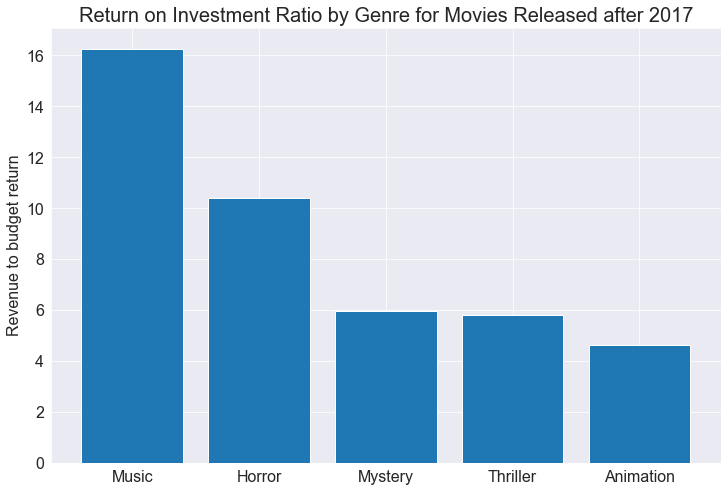

In [23]:
#repeating the same steps as above, but for new movies only

new_movies = movies.loc[movies['year']>2017]
new_movies.reset_index(inplace=True)

new_genre_rois = {}
for row in new_movies.index:
    g_ids = new_movies.iloc[row]['genre_ids']
    rtb = new_movies.iloc[row]['revenue_to_budget']
    for g in g_ids:
        if g in new_genre_rois.keys():
            new_genre_rois[g]=np.append(new_genre_rois[g], rtb)
        else:
            new_genre_rois[g]=np.array([rtb])

new_genre_rois_average = {}
for g in new_genre_rois.keys():
    new_genre_rois_average[g] = new_genre_rois[g].mean()

assert(stats.f_oneway(*new_genre_rois.values())[1]<0.05)

new_movies_genres_and_rois = pd.DataFrame(index=new_genre_rois_average.keys(), data=new_genre_rois_average.values(), columns={'Return on Investment'})
new_movies_genres_and_rois.sort_values(by='Return on Investment', ascending=False, inplace=True)

fig, ax = plt.subplots(figsize=(12,8))
ax.bar(new_movies_genres_and_rois.index[0:5], new_movies_genres_and_rois['Return on Investment'][0:5])
ax.set_title('Return on Investment Ratio by Genre for Movies Released after 2017', fontsize=title_size)
ax.set_ylabel('Revenue to budget return', fontsize=label_size)
ax.set_xticklabels(new_movies_genres_and_rois.index, ha='center', fontsize=label_size);
ax.set_yticklabels(np.arange(0,18,2), size=label_size);


> Horror, mystery, and thriller are still among the most profitable genres, but music has been the most profitable of all recently. Therefore, the top genres we recommend are Horror, Music, Thriller, and Mystery. Next, we will look to see which directors have been the most profitable within these genres.

##

### 5c. Director Analysis

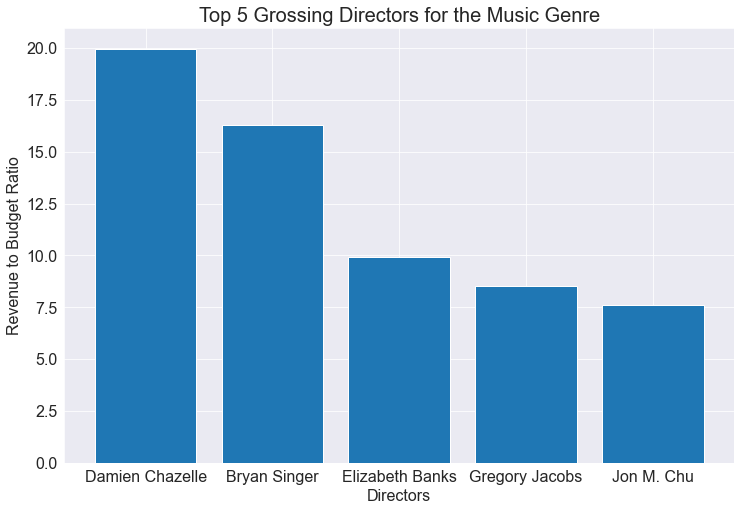

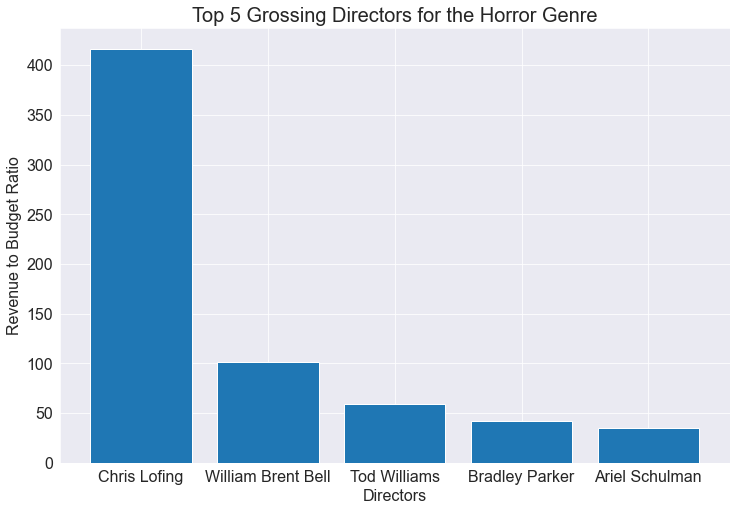

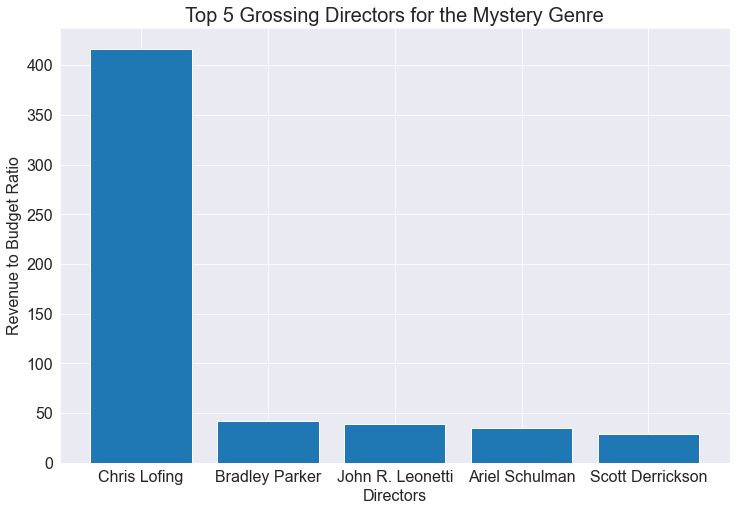

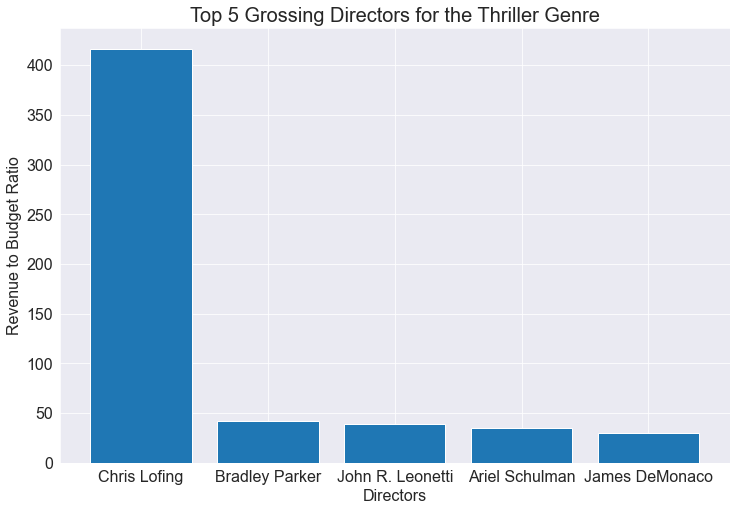

In [43]:
top_5_genres = ['Music', 'Horror', 'Mystery', 'Thriller']

def get_director_roi_ratio(genre, df=movies):
    directors_table = df.loc[(df['genres'].str.contains(genre)) & (df['year'] >= 1900)].groupby(by='primary_name').sum()
    directors_table['revenue_to_budget'] = directors_table['revenue'] / directors_table['budget']
    top_5_directors = directors_table.sort_values(by='revenue_to_budget', ascending=False)[0:5]
    top_5_directors.reset_index(inplace=True)

    return top_5_directors

def plot_director_roi_ratio(genre, top_5_directors):
    fig, ax = plt.subplots(figsize=(12,8))
    ax.bar(top_5_directors['primary_name'], top_5_directors['revenue_to_budget']);
    ax.set_title(f"Top 5 Grossing Directors for the {genre} Genre", fontsize=title_size)
    ax.set_xlabel("Directors", fontsize=label_size)
    ax.set_ylabel("Revenue to Budget Ratio", fontsize=label_size)
    ax.set_xticklabels(top_5_directors['primary_name'], ha='center', fontsize=label_size);
    ax.tick_params(axis='y', labelsize=label_size)

for genre in top_5_genres:
    top_5_directors = get_director_roi_ratio(genre)
    plot_director_roi_ratio(genre, top_5_directors)


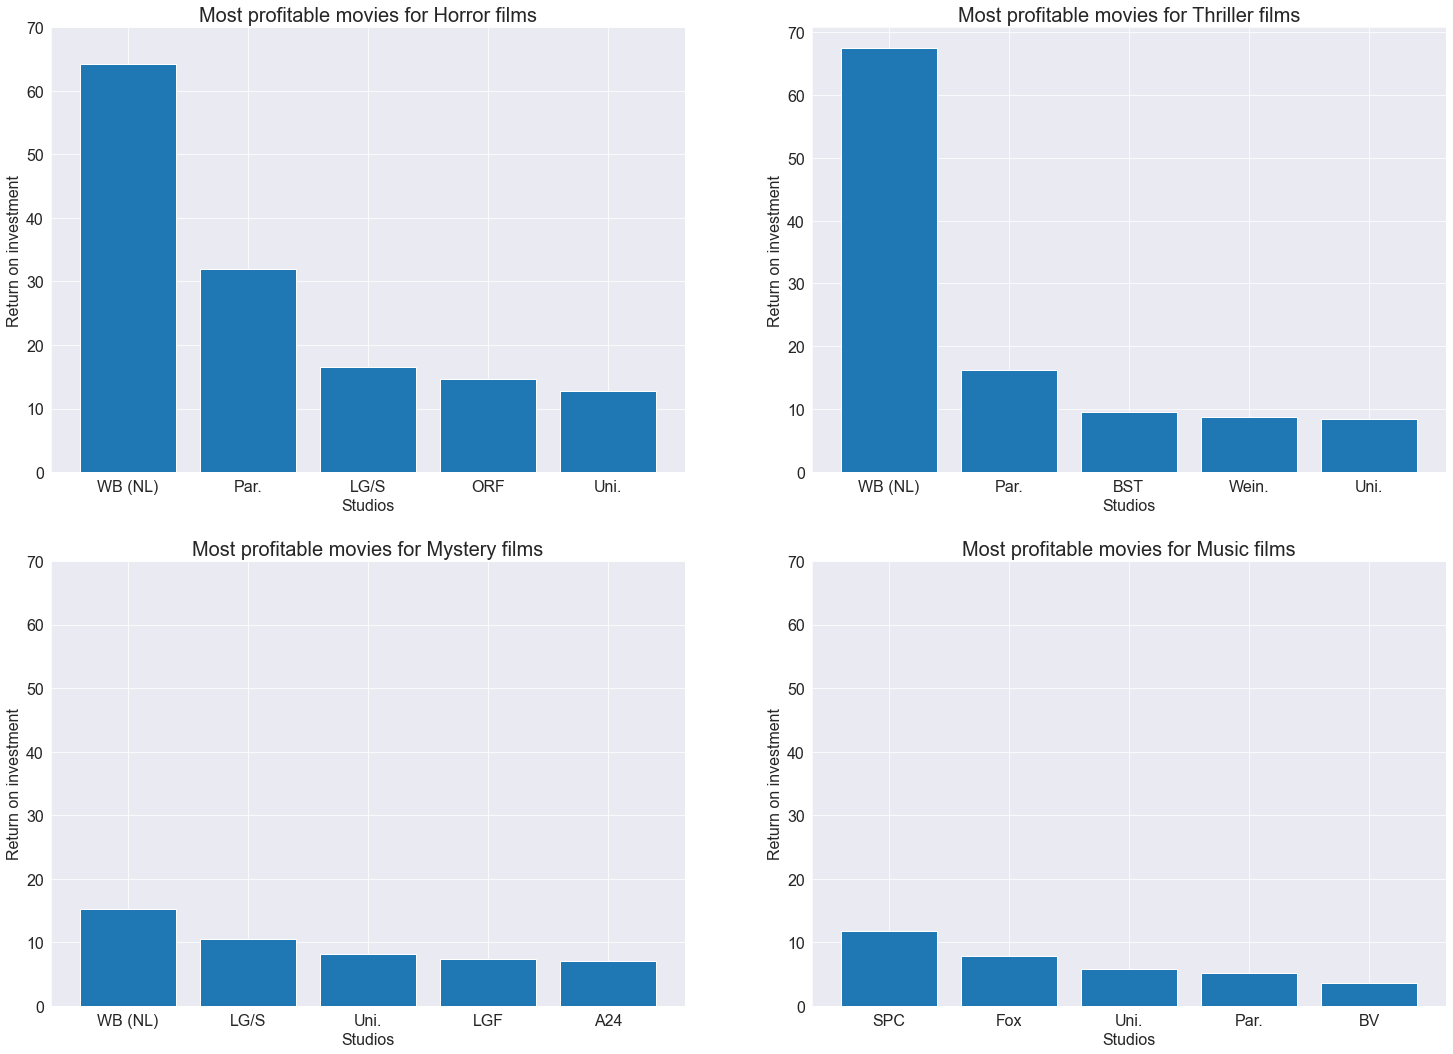

In [25]:
recommended_genres=['Horror', 'Thriller', 'Mystery', 'Music']

#finding the most profitable studio for each genre
studio_revenue_counts = {genre:{} for genre in recommended_genres}
for genre in recommended_genres:
    for i in movies.index:
        genres = movies['genre_ids'].iloc[i]
        s = movies['studio'].iloc[i]
        rtb = movies['revenue_to_budget'].iloc[i]
        for g in genres:
            if g in studio_revenue_counts.keys():
                if s in studio_revenue_counts[g].keys():
                    studio_revenue_counts[g][s] = np.append(studio_revenue_counts[g][s], rtb)
                else:
                    studio_revenue_counts[g][s] = np.array([rtb])

#running a test to see if data is statistically significant
def stat_checker(genre_dict):
    return stats.f_oneway(*genre_dict.values())[1] < 0.05

for genre in recommended_genres:
    assert(stat_checker(studio_revenue_counts[genre]) == True)

#finding the mean of the return on investments for each studio
fig, ax=plt.subplots(ncols=2, nrows=2, figsize=(25,18))
for i, genre in enumerate(recommended_genres):
    studio_average_roi = {}
    for k in studio_revenue_counts[genre].keys():
        studio_average_roi[k] = np.mean(studio_revenue_counts[genre][k])
    df=pd.DataFrame(index=studio_average_roi.keys(), data=studio_average_roi.values(), columns={'Mean_ROI'}).sort_values(by='Mean_ROI', ascending=False)
    ax[i//2][i%2].bar(df.index[:5], df['Mean_ROI'][:5])
    ax[i//2][i%2].set_title(f'Most profitable movies for {genre} films', fontsize=title_size)
    ax[i//2][i%2].set_xlabel('Studios', fontsize=label_size)
    ax[i//2][i%2].set_ylabel('Return on investment',fontsize=label_size)
    ax[i//2][i%2].set_xticklabels(df.index[:5], ha='center', fontsize=label_size);
    ax[i//2][i%2].set_yticklabels(np.arange(0,75,10), size=label_size);    
    ax[i//2][i%2].set_yticks(np.arange(0, 75, 10))